Alunos: Eduardo Traunig, Erick Branquinho Machado

In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

import shap
shap.initjs()

Dados

In [ ]:
# Dataset retirado de: https://www.kaggle.com/datasets/aneevinay/thyroid-cancer-recurrence-dataset
df = pd.read_csv('https://raw.githubusercontent.com/Erick080/T1_ML/refs/heads/main/filtered_thyroid_data.csv')
df.head()

,Age,Gender,Hx Radiothreapy,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [ ]:
# Escolha de separação baseada nas estatísticas disponíveis na página do dataset do kaggle
df['Age_Range'] = pd.cut(df['Age'], bins=[15, 30, 45, 60], labels=['15-30', '31-45', '46-60'])
df = df.drop(columns=['Age'])

# One-hot encoding
df_encoded = pd.get_dummies(df, drop_first=False)
df = df_encoded.drop(columns=['Recurred_No'])
df.head()


,Gender_F,Gender_M,Hx Radiothreapy_No,Hx Radiothreapy_Yes,Adenopathy_Bilateral,Adenopathy_Extensive,Adenopathy_Left,Adenopathy_No,Adenopathy_Posterior,Adenopathy_Right,...,Stage_IVA,Stage_IVB,Response_Biochemical Incomplete,Response_Excellent,Response_Indeterminate,Response_Structural Incomplete,Recurred_Yes,Age_Range_15-30,Age_Range_31-45,Age_Range_46-60
0,True,False,True,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,True,False,False
1,True,False,True,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
2,True,False,True,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,True,False,False
3,True,False,True,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
4,True,False,True,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False


In [ ]:
# Separação de X e y para uso nos modelos de ML
Y = df['Recurred_Yes']
X = df.drop(columns=['Recurred_Yes'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Árvore de Decisão

In [ ]:
decision_tree = DecisionTreeClassifier()

# Usamos o GridSearchCV para achar o modelo
# com a melhor pontuação de Cross Validation
# entre todas as variações dos parâmetros abaixo
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': list(range(2,6)),
    'min_samples_leaf': list(range(1,4)),
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(decision_tree, param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, Y_train)

print(grid_search.best_params_)
print("CrossValidation score no GridSearch:")
print(f"{grid_search.best_score_:.4f}")

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 4}
CrossValidation score no GridSearch:
0.9169


In [ ]:
y_pred = grid_search.predict(X_test)

# Testes de desempenho do modelo:
print('Accuracy:', accuracy_score(Y_test, y_pred))
print('F1:', f1_score(Y_test, y_pred, average='macro'))
print('Precision:', precision_score(Y_test, y_pred, average='macro'))
print('Recall:', recall_score(Y_test, y_pred, average='macro'))

Accuracy: 0.974025974025974
F1: 0.9637476459510358
Precision: 0.9833333333333334
Recall: 0.9473684210526316


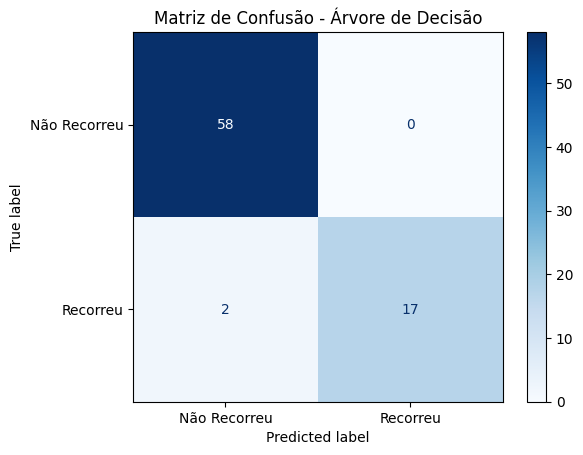

In [ ]:
# Matriz de confusão
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Recorreu', 'Recorreu'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Árvore de Decisão")
plt.show()

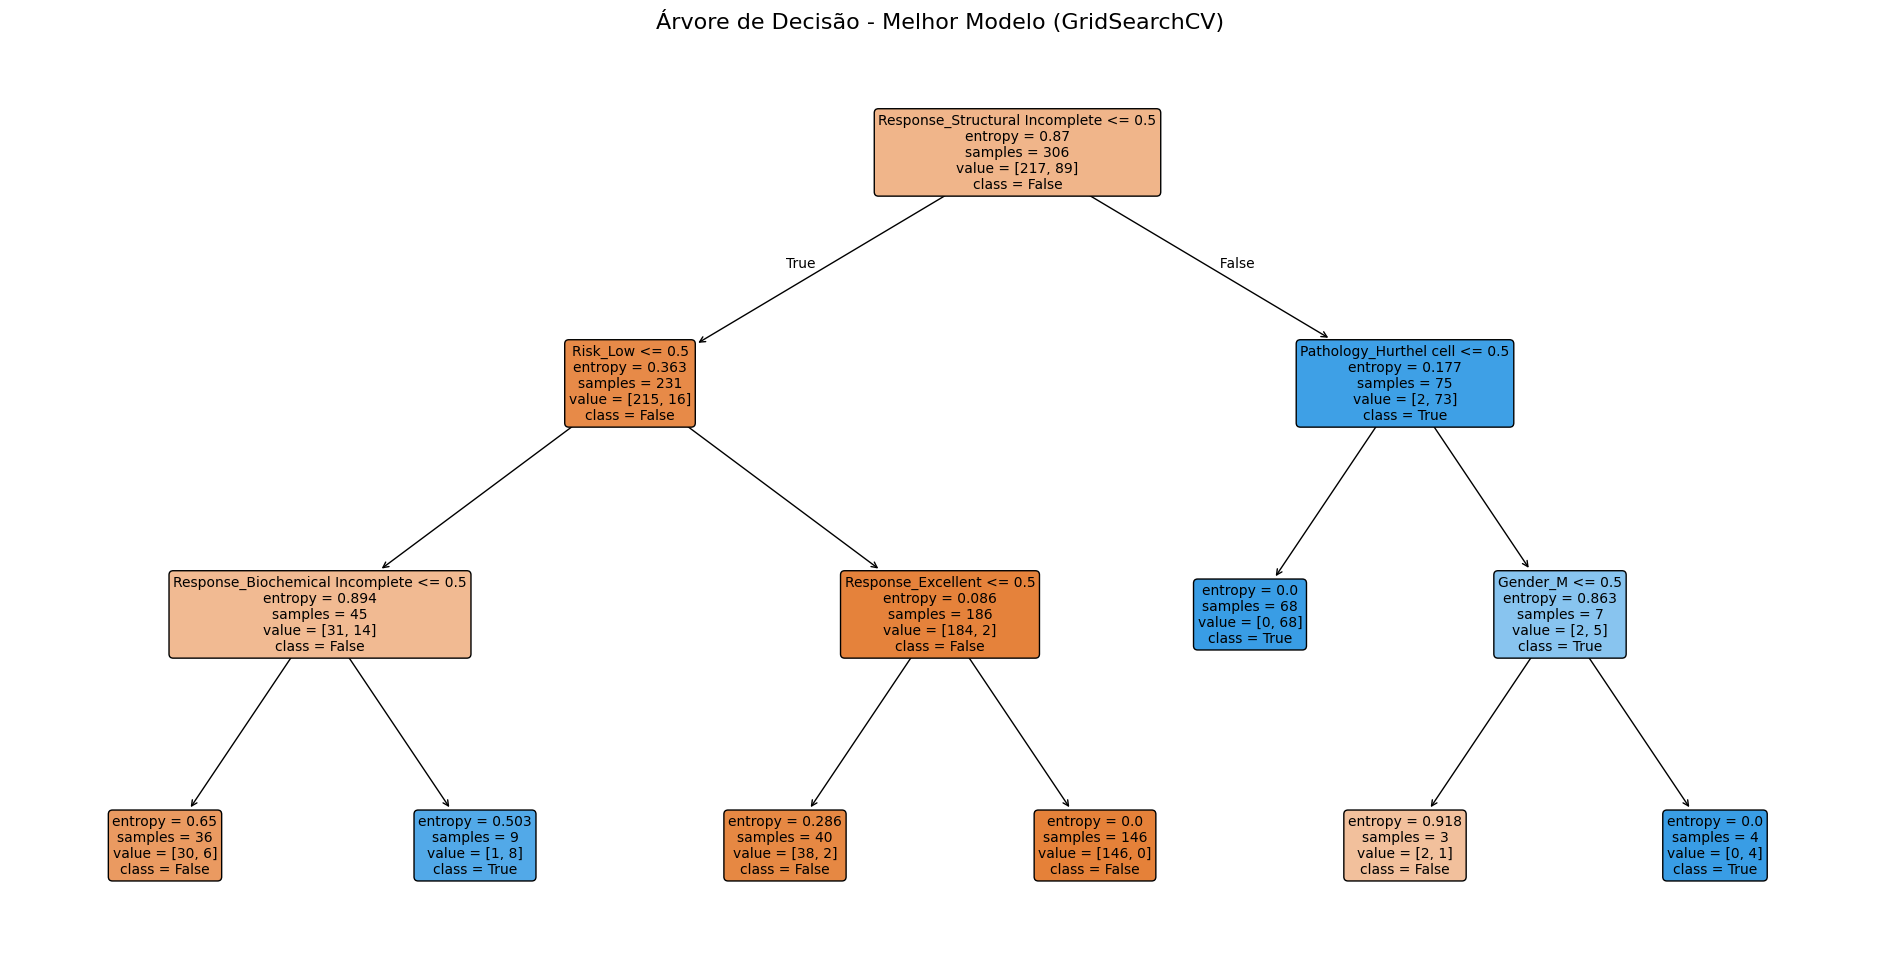

In [ ]:
# Plot da Arvore Gerada
best_tree = grid_search.best_estimator_

class_names = [str(cls) for cls in best_tree.classes_]

plt.figure(figsize=(24, 12))
plot_tree(
    best_tree,
    filled=True,
    feature_names=X_train.columns,
    class_names=class_names,
    rounded=True,
    fontsize=10
)

plt.title("Árvore de Decisão - Melhor Modelo (GridSearchCV)", fontsize=16)
plt.show()

Naive Bayes

In [ ]:
# Naive Bayes multinomial é o mais apropriado para dataframes com muitas variáveis booleanas

# Hyperparametros para o GridSearch
param_grid = {
    'alpha': [0.01, 0.1, 1.0]
}

grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
best_score = grid_search.best_score_

Best parameters: {'alpha': 0.01}
Best cross-validation score: 0.9216287678476996


In [ ]:
y_pred_nb = grid_search.predict(X_test)

# Testes de desempenho do modelo:
print('Accuracy:', accuracy_score(Y_test, y_pred_nb))
print('F1:', f1_score(Y_test, y_pred_nb, average='macro'))
print('Precision:', precision_score(Y_test, y_pred_nb, average='macro'))
print('Recall:', recall_score(Y_test, y_pred_nb, average='macro'))

Accuracy: 0.935064935064935
F1: 0.9110649110649112
Precision: 0.9190207156308852
Recall: 0.9038112522686026


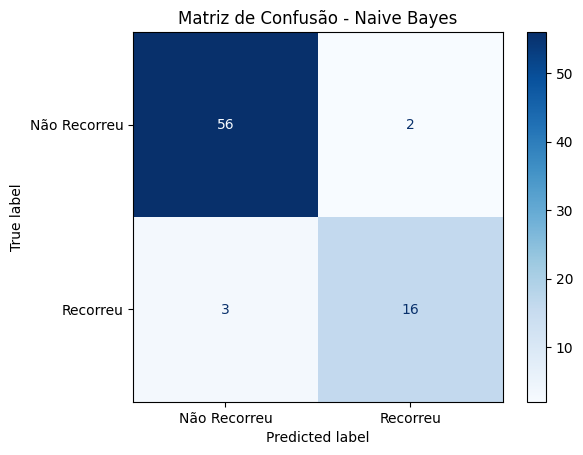

In [ ]:
# Matriz de Confusão
cm_nb = confusion_matrix(Y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['Não Recorreu', 'Recorreu'])
disp_nb.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Naive Bayes")
plt.show()

In [ ]:
classes = ['Nao Recorreu', 'Recorreu']
features = X_train.columns

# Calculando as probabilidades condicionais
probs = np.exp(grid_search.best_estimator_.feature_log_prob_)

df_probs = pd.DataFrame(probs.T, index=features, columns=[f"P(feature|class={c})" for c in classes])
print(df_probs.round(4))

                                 P(feature|class=Nao Recorreu)  \
Gender_F                                                0.0734   
Gender_M                                                0.0104   
Hx Radiothreapy_No                                      0.0835   
Hx Radiothreapy_Yes                                     0.0004   
Adenopathy_Bilateral                                    0.0015   
Adenopathy_Extensive                                    0.0000   
Adenopathy_Left                                         0.0019   
Adenopathy_No                                           0.0746   
Adenopathy_Posterior                                    0.0000   
Adenopathy_Right                                        0.0058   
Pathology_Follicular                                    0.0058   
Pathology_Hurthel cell                                  0.0043   
Pathology_Micropapillary                                0.0128   
Pathology_Papillary                                     0.0611   
Focality_M

KNN


In [ ]:
# GridSearchCV
param_grid = {
      'n_neighbors': [7, 8, 9],
      'weights': ['uniform','distance'],
      'leaf_size': [1, 2, 3, 4, 5],
      'p': [1, 2, 3]
  }

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, n_jobs=-1)
grid_search.fit(X_train, Y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
best_score = grid_search.best_score_

Best parameters: {'leaf_size': 1, 'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
Best cross-validation score: 0.9117398202009518


In [ ]:
y_pred = grid_search.predict(X_test)

# Testes de desempenho do modelo:
print('Accuracy:', accuracy_score(Y_test, y_pred))
print('F1:', f1_score(Y_test, y_pred, average='macro'))
print('Precision:', precision_score(Y_test, y_pred, average='macro'))
print('Recall:', recall_score(Y_test, y_pred, average='macro'))

Accuracy: 0.935064935064935
F1: 0.907563025210084
Precision: 0.9359631147540983
Recall: 0.8861161524500907


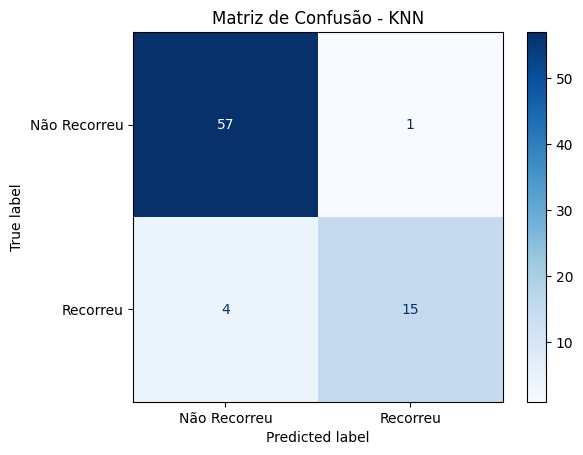

In [ ]:
# Matriz de Confusão
cm_knn = confusion_matrix(Y_test, y_pred)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Não Recorreu', 'Recorreu'])
disp_knn.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - KNN")
plt.show()

Configuracao do SHAP para gerar graficos informativos. O primeiro apresenta as features mais importantes na classificacao das instancias do dataset de treino

PermutationExplainer explainer: 78it [00:28,  2.28it/s]


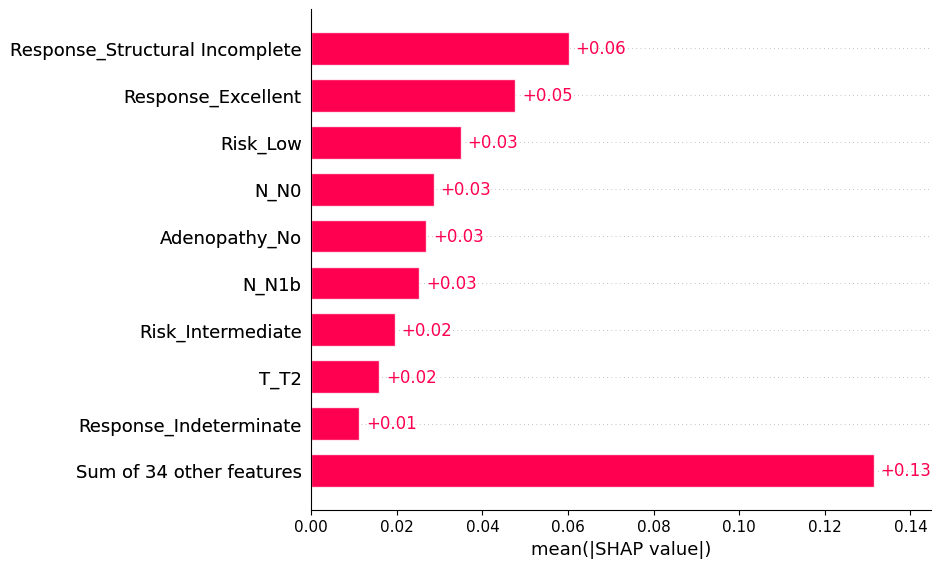

In [ ]:
# Função de predição
def f(x):
    return grid_search.predict_proba(x)[:, 1]

# Conversão dos dados para float64 para funcionar com o SHAP
X_train_asfloat = X_train.astype(np.float64)
X_test_asfloat = X_test.astype(np.float64)

explainer = shap.Explainer(f, X_train_asfloat)

# Calcula valores SHAP
shap_values = explainer(X_test_asfloat.iloc[0:1000, :])

# Exibe gráfico de barras com as top features
shap.plots.bar(shap_values)

No grafico Beeswarm:
 - Cada ponto representa uma instancia
 - A cor representa o valor da feature, no caso de features booleanas, azul representa false e vermelho true
 - O valor SHAP positivo representa a influencia que a feature teve para classificar como *TRUE* a predicao da recorrencia de cancer de tireoide, e o negativo a predicao da nao recorrencia.

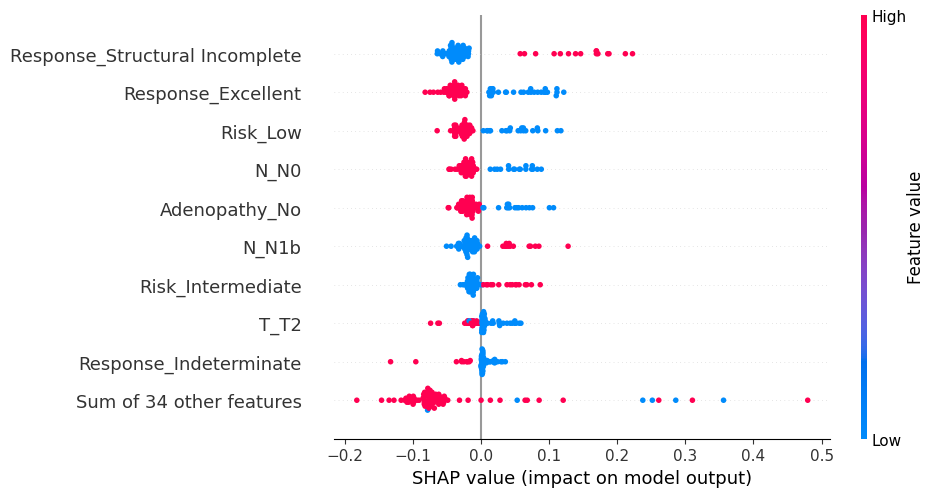

In [ ]:
shap.plots.beeswarm(shap_values)

Comparação dos modelos:
- Árvore de Decisão:
  - O modelo mais entendível, é facil de ver suas escolhas e o porquê de terem sido feitas, uma vez que vemos o plot da árvore final.
  - Foi utilizado o matplotlib e o plot_tree do sklearn para fazer a visualização da árvore.
  - Melhor desempenho entre os 3 modelos (Matriz de confusão).

- Naive Bayes:
  - Não é tão fácil de visualizar quanto uma árvore de decisões desenhada na tela, mas podendo ver as probabilidades das features facilita bastante o entendimento do rumo do algoritmo.
  - Não foi utilizado nenhuma ferramenta especifica para a visualização, apenas a lista com as probabilidades.
  - Melhor que KNN nos testes F1 e recall, e mesma accuracy.

- KNN:
  - O mais difícil de entender, sem sombra de dúvidas, tanto que para poder visualizar ele em um gráfico, seria necessário ter 30+ dimensões. Para poder interpretar ele, foi então necessário usar o SHAP, que nos permite ver quais features são as mais impactantes, inclusive com gráfico de relevância e frequência.
  - Foi utilizado o gráfico de barras e beeswarm do SHAP.
  - Melhor que Naive Bayes no teste Precision, mesma accuracy, e pior nos testes F1 e recall.

In [ ]:
# Testes de desempenho obtidos dos modelos:

# Arvore de decisão --------------- <- Melhor em todos
# Accuracy: 0.974025974025974     |
# F1: 0.9637476459510358          |
# Precision: 0.9833333333333334   |
# Recall: 0.9473684210526316      |

# Naive Bayes ---------------------
# Accuracy: 0.935064935064935     | == Igual KNN
# F1: 0.9110649110649112          | <- Melhor que KNN
# Precision: 0.9190207156308852   |
# Recall: 0.9038112522686026      | <- Melhor que KNN

# KNN -----------------------------
# Accuracy: 0.935064935064935     | == Igual NB
# F1: 0.907563025210084           |
# Precision: 0.9359631147540983   | <- Melhor que NB
# Recall: 0.8861161524500907      |